In [8]:
import mne
import os
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import signal
import array
from datetime import datetime

In [9]:
directory_path = 'Y:/Harry_TMS/Motor'
files = os.listdir(directory_path)
file_name= '20241211_161104_sub-Pilot2_file-Motor1_raw.fif'
data_path=os.path.join(directory_path,file_name)

# Check if the specific file exists
file_exists = os.path.isfile(data_path)

In [10]:
raw = mne.io.read_raw_fif(data_path, preload=True)
events = mne.find_events(raw, stim_channel='di32')
event_id = {
    "misc": 2,
    "misc2": 4,
    "stim_on": 64,
    "stim_off": 208
}


Opening raw data file Y:/Harry_TMS/Motor\20241211_161104_sub-Pilot2_file-Motor1_raw.fif...
    Range : 0 ... 6488799 =      0.000 ...  1297.760 secs
Ready.
Reading 0 ... 6488799  =      0.000 ...  1297.760 secs...
608 events found on stim channel di32
Event IDs: [  2   4  64 208]


In [11]:
raw.pick('meg')
projs = mne.preprocessing.compute_proj_hfc(raw.info, order=2,exclude=['s16_bz'])
raw.add_proj(projs).apply_proj(verbose="error")

8 projection items deactivated


<Raw | 20241211_161104_sub-Pilot2_file-Motor1_raw.fif, 71 x 6488800 (1297.8 s), ~3.43 GiB, data loaded>

In [12]:
tmin, tmax = -0.4, 1.2
lowpass, highpass = 40, 0.1
baseline_tmin, baseline_tmax = -0.4, -0.2  # None takes the first timepoint

In [13]:
raw_filtered = raw.copy().filter(highpass, lowpass)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 165001 samples (33.000 s)



In [14]:
epochs = mne.Epochs(
    raw_filtered,
    events,
    event_id,
    tmin=tmin,
    tmax=tmax,
    detrend=1,
    reject=dict(mag=5e-11),
    baseline=(baseline_tmin,baseline_tmax),
    preload=True,
)

Not setting metadata
608 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 8)
8 projection items activated
Using data from preloaded Raw for 608 events and 8001 original time points ...
    Rejecting  epoch based on MAG : ['L114_bz-s50']
    Rejecting  epoch based on MAG : ['L114_bz-s50']
    Rejecting  epoch based on MAG : ['L114_bz-s50']
    Rejecting  epoch based on MAG : ['L114_bz-s50']
    Rejecting  epoch based on MAG : ['L114_bz-s50']
    Rejecting  epoch based on MAG : ['L114_bz-s50']
    Rejecting  epoch based on MAG : ['R509_bz-s31']
    Rejecting  epoch based on MAG : ['R509_bz-s31']
    Rejecting  epoch based on MAG : ['R509_bz-s31']
    Rejecting  epoch based on MAG : ['R509_bz-s31']
    Rejecting  epoch based on MAG : ['R509_bz-s31']
    Rejecting  epoch based on MAG : ['R411_bz-s15', 'R509_bz-s31', 'R606_bz-s14']
    Rejecting  epoch based on MAG : ['L114_bz-s50']
    Rejecting  epoch based on MAG : ['L114_bz-s5

In [15]:
print(epochs)

<Epochs | 514 events (all good), -0.4 – 1.2 s (baseline -0.4 – -0.2 s), ~2.18 GiB, data loaded,
 'misc': 3
 'misc2': 5
 'stim_on': 252
 'stim_off': 254>


In [16]:
print(epochs.events)  # Displays the events used for epoching
print(epochs.event_id)  # Confirms which event ID was used

[[ 197815       0     208]
 [ 207996       0      64]
 [ 215579       0     208]
 ...
 [6417872       0       2]
 [6423153       0       4]
 [6428029       0       4]]
{'misc': 2, 'misc2': 4, 'stim_on': 64, 'stim_off': 208}


In [17]:
# Get the original channel names
ch_names = epochs.info['ch_names']

# Create a dictionary to rename channels by removing the first 8 characters
rename_dict = {name: name[8:] for name in ch_names}

# Rename the channels using the rename_channels method
epochs.rename_channels(rename_dict)

<Epochs | 514 events (all good), -0.4 – 1.2 s (baseline -0.4 – -0.2 s), ~2.18 GiB, data loaded,
 'misc': 3
 'misc2': 5
 'stim_on': 252
 'stim_off': 254>

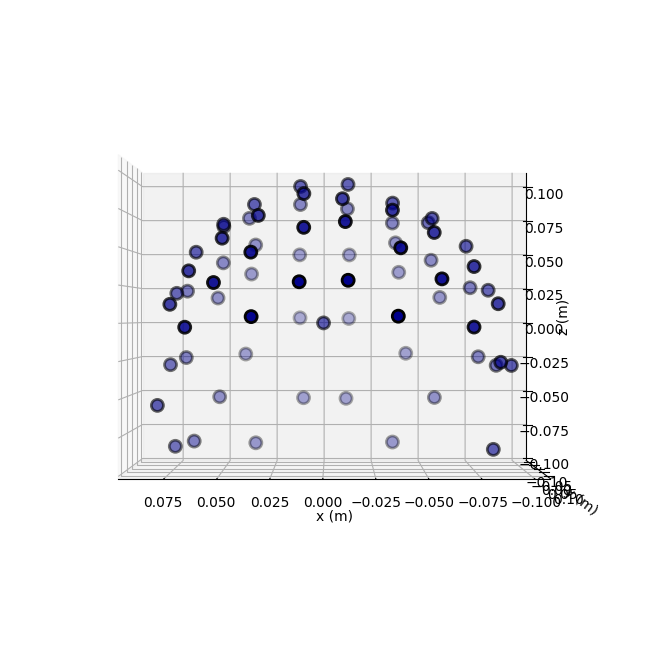

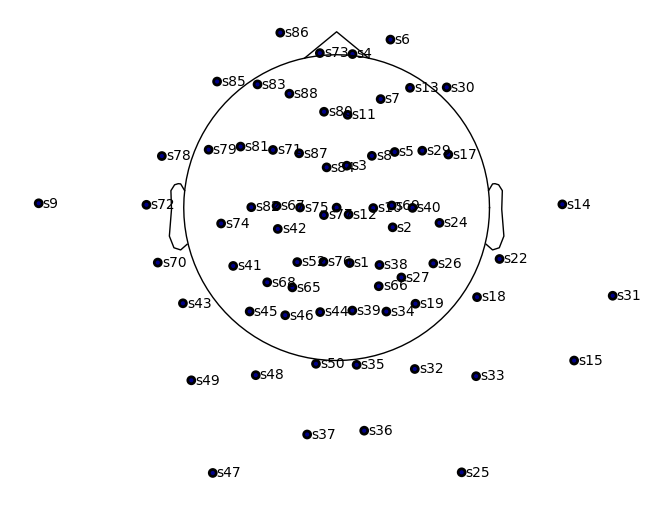

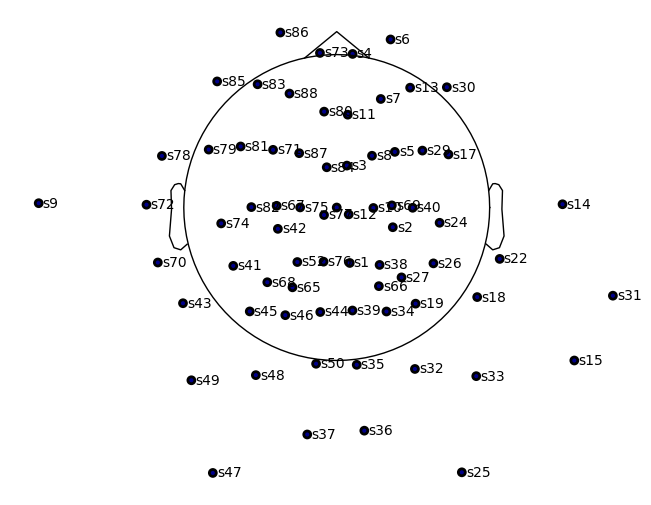

In [18]:
epochs.plot_sensors(kind="3d", ch_type="all")
epochs.plot_sensors(kind="topomap", ch_type="all",show_names=True)

    Using multitaper spectrum estimation with 1 DPSS windows
Plotting amplitude spectral density (dB=True).
Averaging across epochs before plotting...


c:\Users\hxc214\AppData\Local\Programs\PsychoPy\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


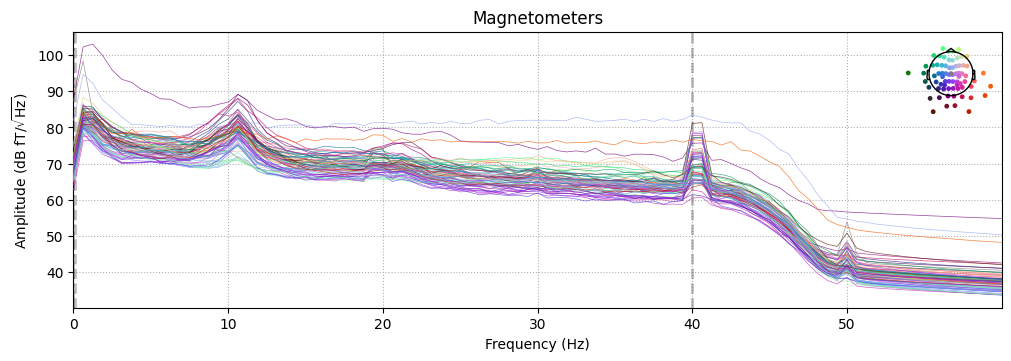

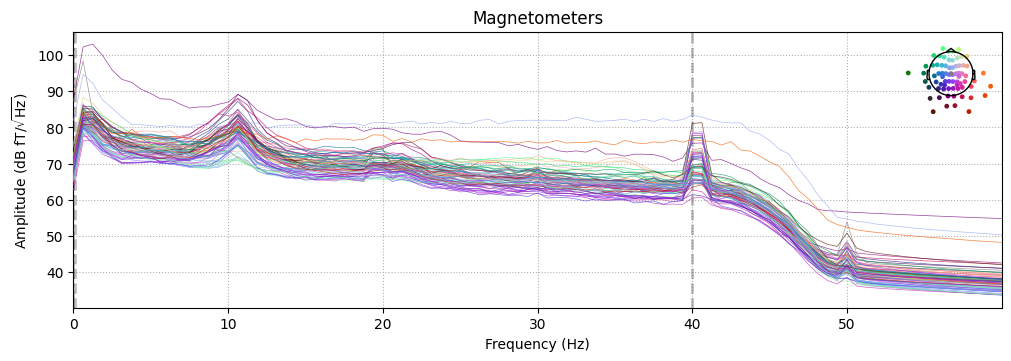

In [19]:
psd = epochs["stim_on"].compute_psd(
    fmax=60, 
    method="multitaper",  # Multitaper is the default
    bandwidth=1          # Smaller value for higher resolution
)
psd.plot(picks="meg", exclude="bads", amplitude=True)


In [20]:
freqs = np.arange(10, 31, 1)
n_cycles = freqs / 2 
time_bandwidth = 2.0

tfr_stim_on =  mne.time_frequency.tfr_multitaper(
    epochs['stim_on'], 
    freqs=freqs, 
    n_cycles=n_cycles,
    time_bandwidth=time_bandwidth, 
    picks = 'mag',
    use_fft=True, 
    return_itc=False,
    average=True, 
    decim=2,
    n_jobs = -1,
    verbose=True)


NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


C:\Users\hxc214\AppData\Local\Temp\ipykernel_7672\2011419038.py:5: RuntimeWarning: joblib not installed. Cannot run in parallel.
  tfr_stim_on =  mne.time_frequency.tfr_multitaper(


No baseline correction applied


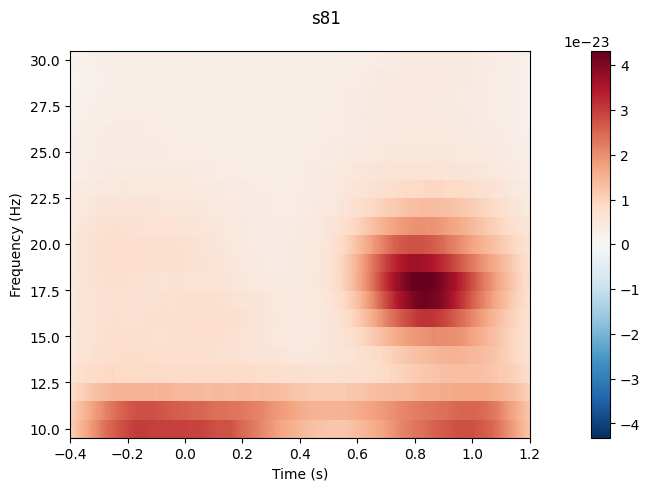

In [21]:
%matplotlib inline
tfr_stim_on.plot(
    picks=['s75'], 
    tmin=-0.5, tmax=1.2, 
    title='s81');   

Applying baseline correction (mode: percent)


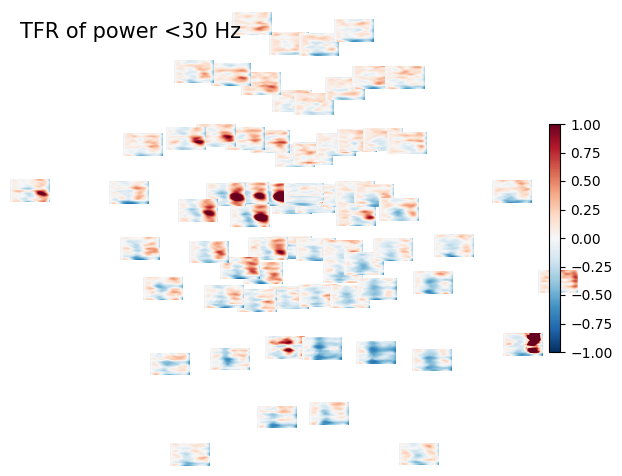

In [22]:

plt = tfr_stim_on.plot_topo(
    tmin=-0.3, tmax=1.2, 
    baseline=[-0.3,-0.2], 
    mode="percent", 
    fig_facecolor='w',
    font_color='k',
    vmin=-1, vmax=1,
    title='TFR of power <30 Hz')